# PREDICTING EPX/USD: A Deep Learning Approach to Cryptocurrency Forecasting


### INTRODUCTION ###

Cryptocurrencies continue to attract attention from traders, analysts, and researchers alike due to their high volatility and growth potential. One such emerging digital asset is EPX (Ellipsis), typically traded against the US Dollar (EPX/USD). Like most crypto pairs, EPX/USD experiences significant price fluctuations, influenced by market demand, liquidity, and broader macroeconomic trends.

Accurate price prediction in such a volatile market can help traders make informed decisions, identify entry and exit points, and minimize risks. In this blog, we explore the use of Gated Recurrent Unit (GRU) networks—a deep learning model well-suited for sequential data—to forecast EPX/USD movements.

In [27]:
# Importing necessary libraries

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']= '-1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Dense,Dropout,Input

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from absl import logging
logging.set_verbosity(logging.ERROR)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf
import random

#Setting seeds to get a consistent output
SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



/kaggle/input/epxusdt-analysis/EPX_USD Binance Historical Data.csv


 **EPX/USD Dataset**

The first few rows of a dataset gives us an understanding of its structure and contents. The columns include:

Date: The date of the trading record.

Price: The closing price at the end of the trading day.

Open: The opening price at the start of the trading day.

High: The highest price reached during the trading day.

Low: The lowest price reached during the trading day.

Vol.: The total trading volume for the day.

Change %: The percentage change in price from the previous trading day.

In [28]:
# Reading and displaying the first fews rows of the dataset

file_path = '/kaggle/input/epxusdt-analysis/EPX_USD Binance Historical Data.csv'
df = pd.read_csv(file_path)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,05/21/2024,0.000192,0.000187,0.000202,0.000185,10.86B,3.22%
1,05/20/2024,0.000186,0.000179,0.000187,0.000175,8.07B,3.79%
2,05/19/2024,0.000179,0.000200,0.000200,0.000175,20.31B,-11.49%
3,05/18/2024,0.000203,0.000181,0.000225,0.000176,32.66B,12.49%
4,05/17/2024,0.000180,0.000171,0.000186,0.000169,5.21B,5.69%


In [29]:
# Summary statistics of the numerical coloumns
df.describe()

,Price,Open,High,Low
count,726.000000,726.000000,726.000000,726.000000
mean,0.000339,0.000341,0.000359,0.000326
std,0.000185,0.000191,0.000208,0.000175
min,0.000165,0.000165,0.000170,0.000159
25%,0.000211,0.000210,0.000216,0.000205
50%,0.000296,0.000296,0.000305,0.000287
75%,0.000406,0.000407,0.000427,0.000386
max,0.001618,0.001629,0.001793,0.001559


In [30]:
# Checking the dataset for missing values
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [31]:
# Sorting and setting index
file_path = '/kaggle/input/epxusdt-analysis/EPX_USD Binance Historical Data.csv'
df = pd.read_csv(file_path,parse_dates = ["Date"],header=0)
df =df.sort_values("Date")
df = df.set_index("Date")


**Indicators: Support and Resistance**

In addition to raw price data, technical indicators like support and resistance levels provide valuable context.

Support: A price level where buying pressure tends to outweigh selling pressure, preventing further decline.

Resistance: A price level where selling pressure typically exceeds buying pressure, preventing further rise.


In [32]:
# Creating new coloumns in dataset for support and resistance indicators

support_w=20
resist_w=20
df["Support"] = df["Price"].rolling(window=support_w,min_periods=support_w).min()
df["Resistance"] = df["Price"].rolling(window=resist_w,min_periods=resist_w).max()


# Distance from support and Resistance lines

df["Dist_to_Support"] = df["Price"] - df["Support"]

df["Dist_to_Resistance"] = df["Resistance"]-df["Price"]

df=df.dropna()
df.head()

,Price,Open,High,Low,Vol.,Change %,Support,Resistance,Dist_to_Support,Dist_to_Resistance
Date,,,,,,,,,,
2022-06-15,0.000644,0.000631,0.000668,0.000545,4.83B,2.55%,0.000628,0.001618,0.000016,0.000974
2022-06-16,0.000565,0.000641,0.000649,0.000555,2.17B,-12.27%,0.000565,0.001464,0.000000,0.000899
2022-06-17,0.000542,0.000565,0.000677,0.000494,9.58B,-4.07%,0.000542,0.001464,0.000000,0.000922
2022-06-18,0.000499,0.000542,0.000552,0.000458,5.53B,-7.93%,0.000499,0.001391,0.000000,0.000892
2022-06-19,0.000529,0.000499,0.000531,0.000475,3.62B,6.01%,0.000499,0.001265,0.000030,0.000736


In [33]:
#Selection of Features and Target
feature_cols=["Price","Support","Resistance","Dist_to_Support","Dist_to_Resistance"]
target_col = ["Price"]

features = df[feature_cols].copy()
target = df[target_col].copy()
start_date = pd.DataFrame()

start_date["Date"] = df.index
date_col = start_date["Date"]
#print(date_col)

In [34]:
# Splitting Data into Training set,Validation set and Test set

n=len(df)
train_end=int(n*.7)
val_end=int(n*.85)

X_train_raw = features.iloc[:train_end]
y_train_raw= target.iloc[:train_end]

X_val_raw = features.iloc[train_end:val_end]
y_val_raw = target.iloc[train_end:val_end]

X_test_raw=features.iloc[val_end:]
y_test_raw = target.iloc[val_end:]
date_index = date_col.iloc[val_end:] 


  
 **Data Preprocessing**

When working with machine learning models, it’s important to ensure that features are on a comparable scale. Many algorithms (like gradient descent, k-means, and neural networks) perform better when numeric values are normalized.
MinMaxScaler from scikit-learn is one of the most popular normalization techniques. It transforms each feature individually by scaling its values into a fixed range, usually [0, 1].

The fit_transform() method is used during preprocessing to both:

1.Learn the parameters from the training data.

2.Apply the learned scaling to the data.

In [35]:
# Preprocessing of sets

feat_scaler = MinMaxScaler()
tgt_scaler = MinMaxScaler()

X_train_raw = np.array(X_train_raw)
X_val_raw = np.array(X_val_raw)
X_test_raw = np.array(X_test_raw)

X_train_scaled = feat_scaler.fit_transform(X_train_raw)
X_val_scaled = feat_scaler.transform(X_val_raw)
X_test_scaled = feat_scaler.transform(X_test_raw)

y_train_raw = np.array(y_train_raw).reshape(-1,1)
y_val_raw = np.array(y_val_raw).reshape(-1,1)
y_test_raw = np.array(y_test_raw).reshape(-1,1)


y_train_scaled = tgt_scaler.fit_transform(y_train_raw)
y_val_scaled= tgt_scaler.transform(y_val_raw)
y_test_scaled = tgt_scaler.transform(y_test_raw)


In [36]:
# Creating a function for making sequences

def make_sequences(X2D,y2D,lookback):
    X_list,y_list=[],[]
    for i in range(lookback,len(X2D)):
         X_list.append(X2D[i-lookback:i,:])
         y_list.append(y2D[i,0])
    return np.array(X_list),np.array(y_list)

lookback=74

X_train,y_train = make_sequences(X_train_scaled,y_train_scaled,lookback)

X_val,y_val = make_sequences(X_val_scaled,y_val_scaled,lookback)

X_test,y_test = make_sequences(X_test_scaled,y_test_scaled,lookback)


**GRU Model for Cryptocurrency Prediction**

Time-series forecasting, such as predicting cryptocurrency prices, requires models that can capture temporal dependencies in historical data. Traditional machine learning models (like linear regression or random forests) often fail to handle the sequential nature of price data effectively.

This is where Recurrent Neural Networks (RNNs) come into play. Among RNN architectures, GRU (Gated Recurrent Unit) and LSTM (Long Short-Term Memory) are widely used. 

Time series often involve both short-term patterns (daily/weekly) and long-term trends (monthly/seasonal).GRU captures Long-Term dependencies well enough.
While LSTM was designed to handle long-term dependencies, GRU achieves similar performance without the extra complexity.

GRUs capture short-term dependencies well, and with proper training + hyperparameter tuning, they can also capture medium/long-term dependencies.

Because GRUs have fewer parameters, they tend to generalize better on smaller datasets—which is common in financial/stock/cryptocurrency time series.



In [37]:
# GRU model
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']= '-1'

lookback=74
model=Sequential([
                  Input(shape=(lookback,X_train.shape[2])),
                  GRU(64,return_sequences=True),
                  Dropout(0.2),
                  GRU(64),
                  Dropout(0.2),
                  Dense(1)])

model.compile(optimizer="adam",loss = "mse")
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 74, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 74, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Training 

es = EarlyStopping(monitor="val_loss",patience = 8,restore_best_weights=True)
ckpt= ModelCheckpoint("best_gru_sr.keras",monitor = "val_loss",save_best_only = True)

history = model.fit(X_train,y_train,validation_data = (X_val,y_val),epochs=100,batch_size=32,callbacks = [es,ckpt],verbose =1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - loss: 0.0349 - val_loss: 6.8474e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0027 - val_loss: 2.2816e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0021 - val_loss: 2.1224e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0018 - val_loss: 2.4613e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0024 - val_loss: 1.8601e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0019 - val_loss: 1.7326e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0021 - val_loss: 1.7191e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0020 - val_loss: 1.7476e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0020 - val_loss: 1.5948e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0018 - val_loss: 1.6191e-04
Ep

**Performance Metrics**

Mean Absolute Error (MAE)
The average of the absolute differences between predicted and actual values.
It tells you how far off your predictions are, on average, in the same units as your data.

Root Mean Squared Error (RMSE)
The square root of the average of squared differences between predicted and actual values.Like MAE, but gives more weight to larger errors.

Accuracy Insights
Lower MAE and RMSE = better predictive accuracy.


In [39]:
# Evaluation on test set

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

y_test_pred_scaled = model.predict(X_test)
y_test_pred = tgt_scaler.transform(y_test_raw[lookback:].reshape(-1,1))*0
y_test_pred = tgt_scaler.inverse_transform(y_test_pred_scaled)

actual_test=pd.DataFrame()

#Align actuals to the same indices used for sequences
x= y_test_raw[lookback:].copy()
x = pd.DataFrame(x)
d= date_index.iloc[lookback:].copy()

actual_test =  x 

y_testpred = y_test_pred.copy()
y_testpred =pd.DataFrame(y_testpred)

actual_test.loc[:,"Pred"] = y_testpred
actual_test.loc[:,"Target_col"]= actual_test[0] 
actual_test.loc[:,'Date'] = d.values
actual_test = actual_test.set_index("Date")

mae = mean_absolute_error(actual_test["Target_col"],actual_test["Pred"])
rmse = mean_squared_error(actual_test["Target_col"],actual_test["Pred"],squared = False)
print(f"Test MAE:{mae:.6f}|Test RMSE:{rmse:.6f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Test MAE:0.000007|Test RMSE:0.000009


In [40]:
# Prediction for the next day

# Take the last "lookback" steps from the full scaled feature set

full_scaled = feat_scaler.transform(features.values)
last_seq = full_scaled[-lookback:,:].reshape(1,lookback,full_scaled.shape[1])
next_scaled=model.predict(last_seq)
next_close = tgt_scaler.inverse_transform(next_scaled)[0,0]
print(f"Next-day predicted close:{next_close:.6f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Next-day predicted close:0.000186


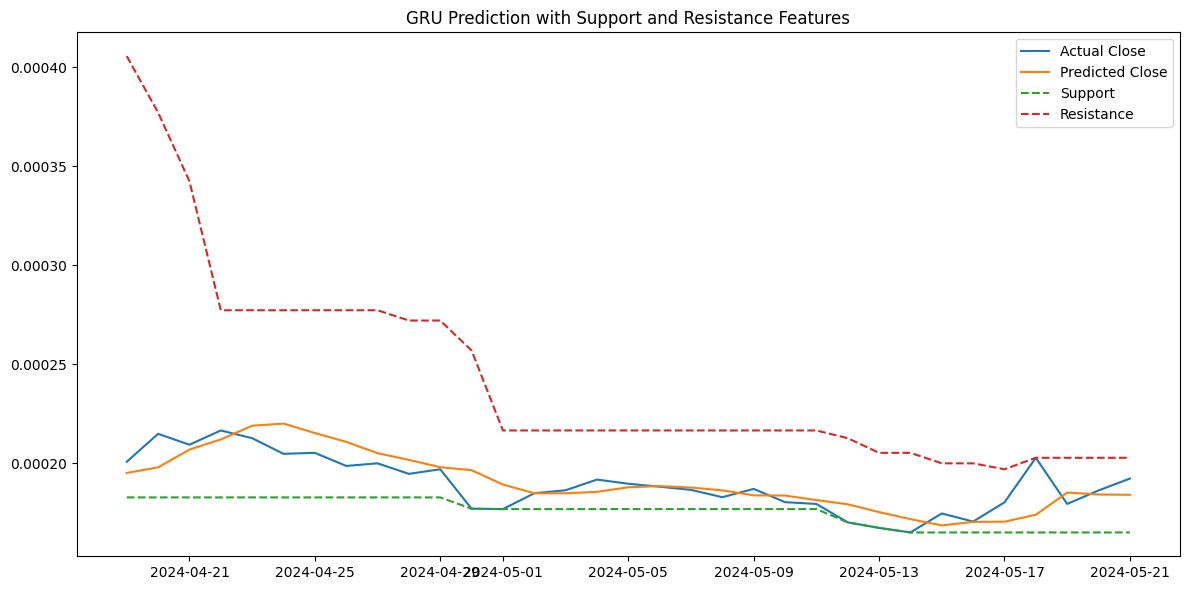

In [41]:
# Plotting GRU Prediction with Support and Resistance Features

test_index = actual_test.index

# Convert RangeIndex to DateTimeIndex 
if isinstance(test_index, pd.RangeIndex):
    test_index = pd.date_range(start='2022-03-06', periods=len(test_index), freq='D')
    actual_test.index = test_index  # Update index so plots align

# Plot actual vs predicted close prices
plt.figure(figsize=(12, 6))
plt.plot(test_index, actual_test["Target_col"].values, label="Actual Close")
plt.plot(test_index, actual_test["Pred"].values, label="Predicted Close")

# Plot support and resistance
sr_vis = df.iloc[val_end + lookback: ]  # align to test plot 


if isinstance(sr_vis.index, pd.RangeIndex):
    sr_vis.index = pd.date_range(start='2024-03-06', periods=len(sr_vis), freq='D')
    sr_vis.index = test_index

plt.plot(sr_vis.index, sr_vis["Support"].values, linestyle="dashed", label="Support")
plt.plot(sr_vis.index, sr_vis["Resistance"].values, linestyle="dashed", label="Resistance")

# Final plot settings
plt.title("GRU Prediction with Support and Resistance Features")
plt.legend()
plt.tight_layout()
plt.show()

**Evaluation Metrics: MAPE and Accuracy**

To measure how well the GRU model performs, two important metrics are used:

Mean Absolute Percentage Error (MAPE)

MAPE measures the average percentage error between predicted and actual values.

A lower MAPE indicates higher accuracy, making it a standard for regression-based forecasting.

**Accuracy(Regression Adaptation)**

In regression problems, accuracy can be defined as how close predictions are within a certain threshold of the actual value.

Combining both metrics provides a balanced view: MAPE quantifies overall error, while accuracy indicates practical usefulness in real trading conditions

Estimating Accuracy from MAPE

MAPE (Mean Absolute Percentage Error) is actually a measure of inaccuracy, but you can flip it to get a sense of accuracy too.

Estimating Accuracy

Since MAPE tells you the average percentage error, you can estimate accuracy like this:

Estimated Accuracy (%) = 100% − MAPE (%)


In [42]:
import tensorflow as tf

# Calculating accuracy of the prediction using MAPE

def prediction_accuracy(y_true,y_pred,tolerance=0.05): 

    mape = tf.reduce_mean(tf.abs((y_true-y_pred)/y_true))*100
    print('Value of MAPE',mape)
    accuracy_percent = 100-mape
    accuracy_percent = round(accuracy_percent.numpy(),2)
    return accuracy_percent

accuracy = prediction_accuracy(actual_test["Target_col"],actual_test["Pred"])

print('Accuracy of prediction in percentage:',accuracy) 



Value of MAPE tf.Tensor(3.585741965881231, shape=(), dtype=float64)
Accuracy of prediction in percentage: 96.41


**Conclusion**

Predicting cryptocurrency prices like EPX/USD is inherently challenging due to volatility and external market influences. However, with advanced deep learning techniques such as GRU and enriched with support/resistance indicators, we can build models that provide valuable insights.

By evaluating results through MAPE and accuracy, traders and researchers can better assess the reliability of forecasts and incorporate them into decision-making.

In the fast-paced world of crypto trading, such predictive models don’t guarantee profits—but they do offer a data-driven edge in navigating uncertainty.